# Spectrally Normalized Generative Adversarial Networks (SN-GAN)

**Goals**

In this notebook, you'll learn about and implement **spectral normalization**, a weight normalization technique to stabilize the training of the discriminator, as proposed in [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957) (Miyato et al. 2018).

**Background**

As its name suggests, SN-GAN normalizes the weight matrices in the discriminator by their corresponding [spectral norm](https://calculus.subwiki.org/wiki/Spectral_norm#:~:text=The%20spectral%20norm%20of%20a,where%20denotes%20the%20Euclidean%20norm.), which helps control the Lipschitz constant of the discriminator. As you have learned with WGAN, [Lipschitz continuity](https://en.wikipedia.org/wiki/Lipschitz_continuity) is important in ensuring the boundedness of the optimal discriminator. In the WGAN case, this makes it so that the underlying W-loss function for the discriminator (or more precisely, the critic) is valid.

As a result, spectral normalization helps improve stability and avoid vanishing gradient problems, such as mode collapse.

## DCGAN with Spectral Normalization

In rest of this notebook, you will walk through how to apply spectral normalization to DCGAN as an example, using your earlier DCGAN implementation. You can always add spectral normalization to your other models too.

Here, you start with the same setup and helper function, as you've seen before. 

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!


/Users/vishalmaurya/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor+ 1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### DCGAN Generator

Since spectral normalization is only applied to the matrices in the discriminator, the generator implementation is the same as the original.

In [36]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim*4),
            self.make_gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim*2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.Tanh()
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_sample, z_dim, device='cpu'):
    return torch.randn(n_sample, z_dim, device=device)

In [40]:
# unit test for generator class
def test_generator(num_test=100):
    gen = Generator()

    test_hidden_noise = get_noise(num_test, gen.z_dim) # (100, 10)
    test_hidden_block = gen.make_gen_block(10, 20, 4, 1)
    test_uns_noise = gen.unsqueeze_noise(test_hidden_noise) # (100, 10, 1, 1)
    hidden_output = test_hidden_block(test_uns_noise) # (100, 20, 4, 4)

    # Check that it works with other strides
    test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

    test_final_noise = get_noise(num_test, gen.z_dim) * 20
    test_final_block = gen.make_gen_block(10, 20, final_layer=True)
    test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
    final_output = test_final_block(test_final_uns_noise)
    # print(final_output.shape)
    # Test the whole thing:
    test_gen_noise = get_noise(num_test, gen.z_dim)
    test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
    gen_output = gen(test_uns_gen_noise)

    assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
    assert hidden_output.max() > 1
    assert hidden_output.min() == 0
    assert hidden_output.std() > 0.2
    assert hidden_output.std() < 1
    assert hidden_output.std() > 0.5

    assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)
    assert final_output.max().item() == 1
    assert final_output.min().item() == -1
    
    assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
    assert gen_output.std() > 0.5
    assert gen_output.std() < 0.8
    print("Success!")

test_generator()


Success!


### DCGAN Discriminator

For the discriminator, you can wrap each `nn.Conv2d` with `nn.utils.spectral_norm`. In the backend, this introduces parameters for $\tilde{u}$ and $\tilde{v}$ in addition to $W$ so that the $W_{SN}$ can be computed as $\tilde{u}^\top W\tilde{v}$ in runtime.

Pytorch also provides a `nn.utils.remove_spectral_norm` function, which collapses the 3 separate parameters into a single explicit $\overline{W}_{SN} := \tilde{u}^\top W\tilde{v}$. You should only apply this to your convolutional layers during inference to improve runtime speed.

It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer. You can see both in a discriminator architecture, but you can also see just one of them. Hope this is something you have fun experimenting with!

In [60]:
# discriminator class
class Discriminator(nn.Module):
    def __init__(self, im_chan = 1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim*2),
            self.make_disc_block(hidden_dim*2, 1, final_layer=True)
        )
    
    def make_disc_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                torch.nn.utils.spectral_norm(
                    nn.Conv2d(input_channels, output_channels, kernel_size, stride)

                ),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride)
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### Training SN-DCGAN

You can now put everything together and train a spectrally normalized DCGAN! Here are all your parameters for initialization and optimization. 

In [48]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course
beta_1 = 0.5 
beta_2 = 0.999
device = 'cpu'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [61]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

disc = Discriminator()
disc_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

AttributeError: 'function' object has no attribute 'spectral_norm'

  7%|▋         | 31/469 [00:13<03:22,  2.17it/s]

Step 500: Generator loss: 0.6526269958019261, discriminator loss: 0.7106288312673574


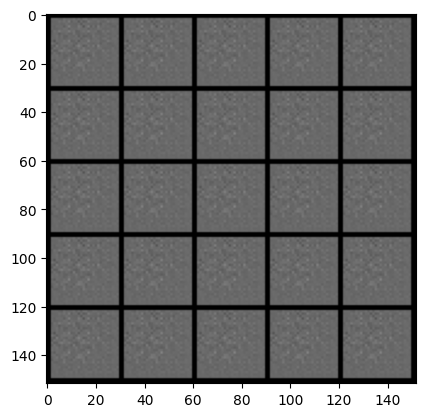

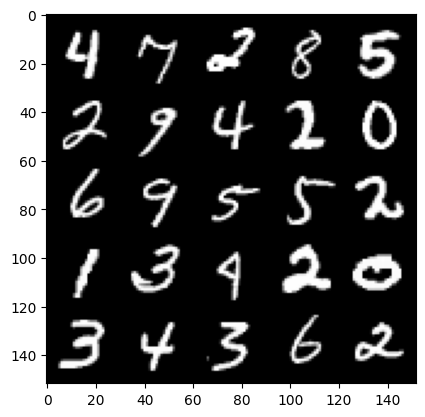

 13%|█▎        | 62/469 [00:25<02:52,  2.36it/s]

Step 1000: Generator loss: 0.650426419973374, discriminator loss: 0.7096964616775515


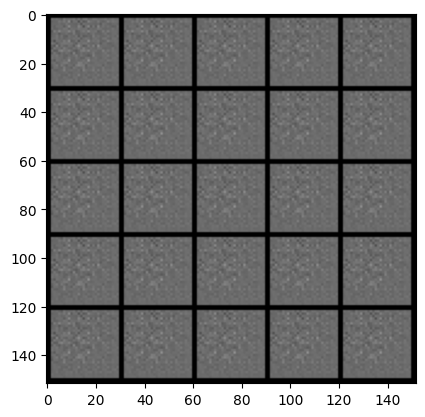

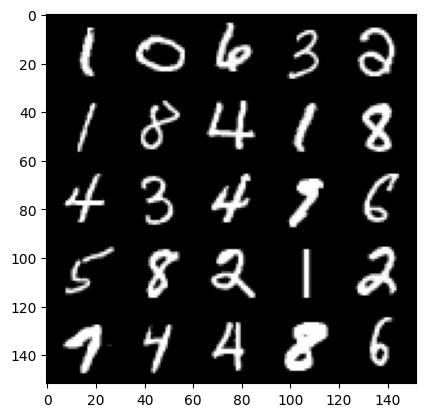

 20%|█▉        | 93/469 [00:50<03:25,  1.83it/s]

Step 1500: Generator loss: 0.6503772354125976, discriminator loss: 0.7097241786718372


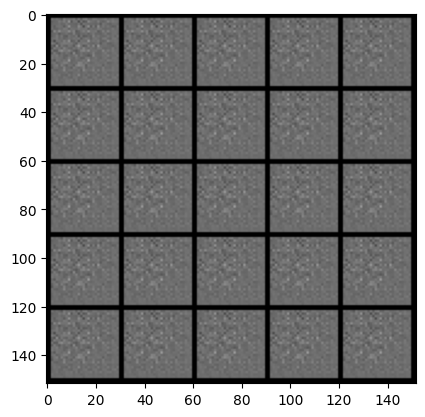

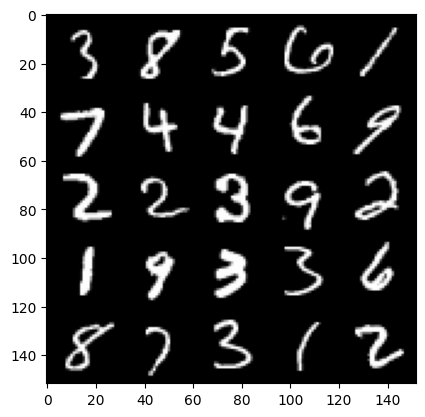

 26%|██▋       | 124/469 [01:05<02:53,  1.98it/s]

Step 2000: Generator loss: 0.6503607243299484, discriminator loss: 0.7097331373691559


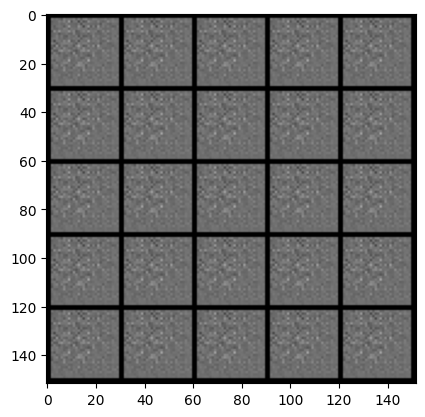

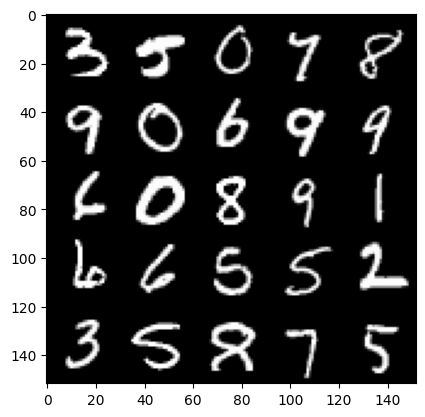

 33%|███▎      | 155/469 [01:19<02:39,  1.97it/s]

Step 2500: Generator loss: 0.6503526245355612, discriminator loss: 0.7097391130924231


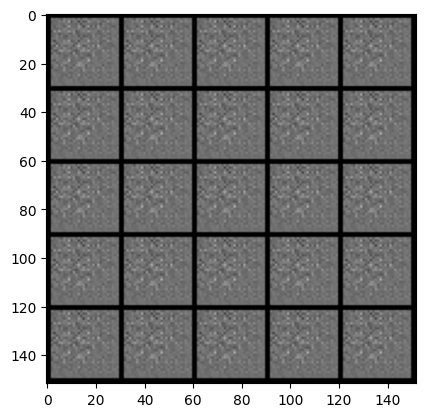

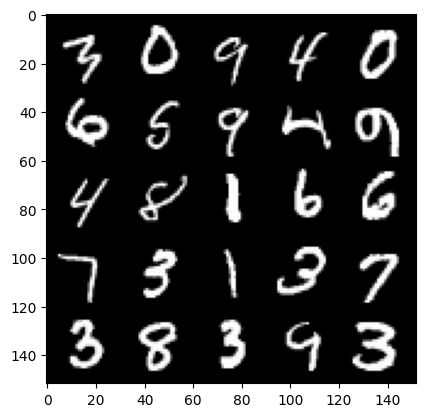

 40%|███▉      | 186/469 [01:38<02:25,  1.94it/s]

Step 3000: Generator loss: 0.6503470113277431, discriminator loss: 0.7097387766838075


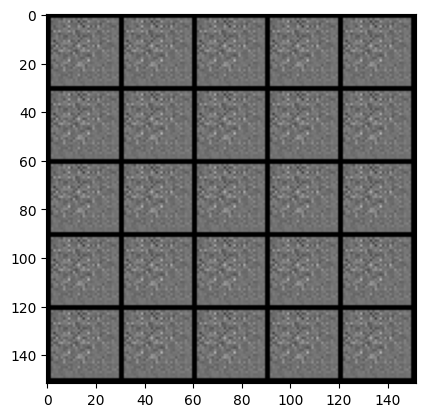

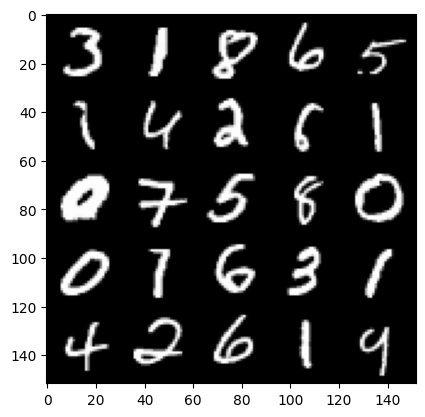

 46%|████▋     | 217/469 [18:50<02:23,  1.76it/s]    

Step 3500: Generator loss: 0.6503429064750673, discriminator loss: 0.7097417206764226


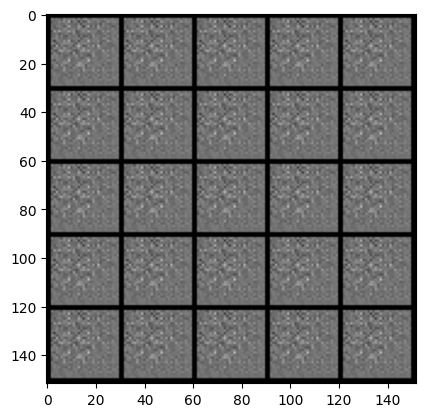

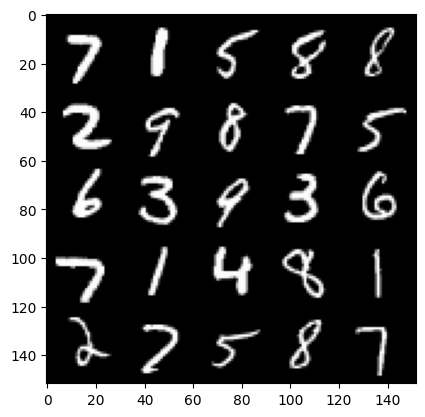

 53%|█████▎    | 248/469 [19:44<01:56,  1.90it/s]   

Step 4000: Generator loss: 0.6503395558595655, discriminator loss: 0.7097481584548949


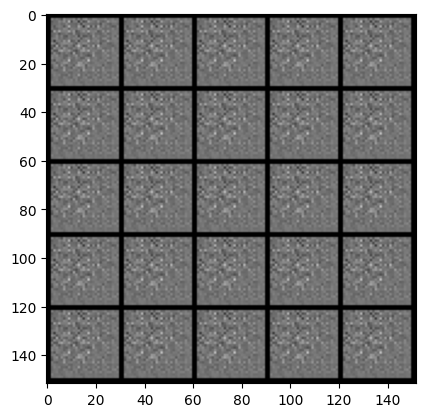

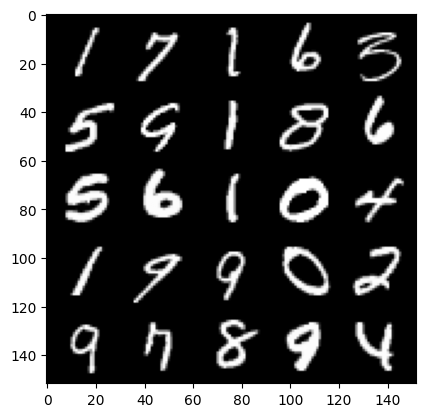

 59%|█████▉    | 279/469 [02:21<01:36,  1.98it/s]

Step 4500: Generator loss: 0.6503366746902466, discriminator loss: 0.7097485178709024


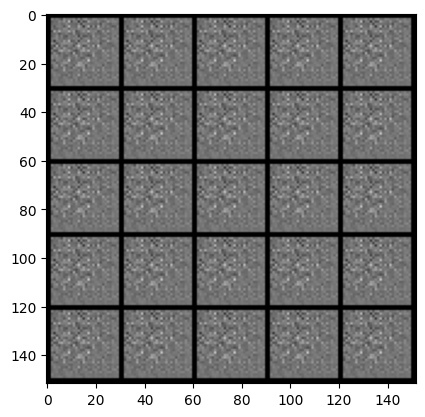

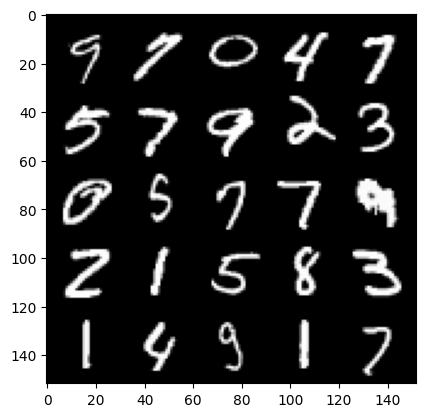

 66%|██████▌   | 310/469 [02:37<01:20,  1.98it/s]

Step 5000: Generator loss: 0.6503344210386276, discriminator loss: 0.709743773937225


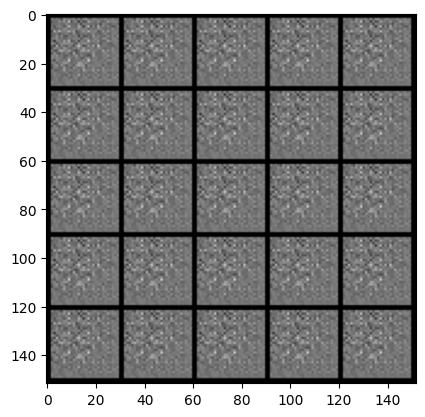

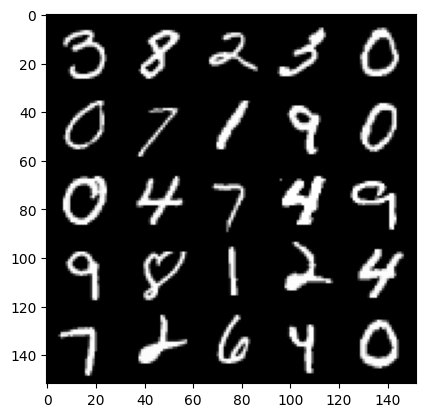

 73%|███████▎  | 341/469 [03:13<01:19,  1.61it/s]

Step 5500: Generator loss: 0.6503328526020057, discriminator loss: 0.7097519584894182


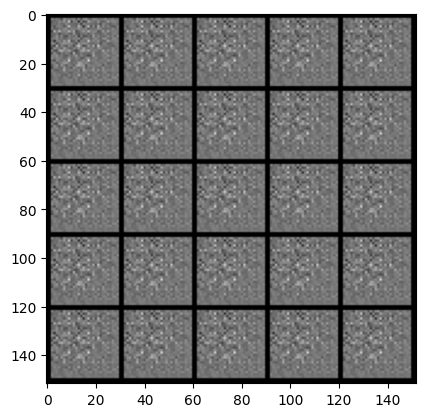

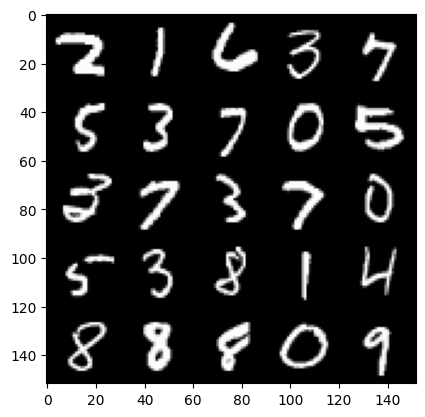

 79%|███████▉  | 372/469 [04:14<01:12,  1.33it/s]

Step 6000: Generator loss: 0.6503315227031712, discriminator loss: 0.7097473287582398


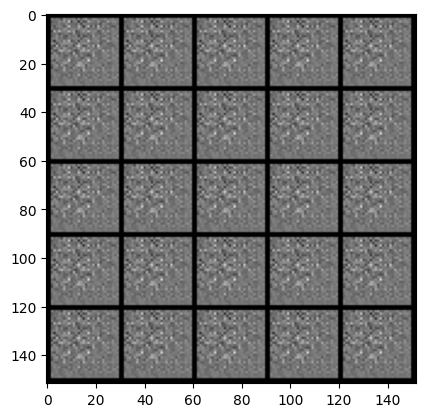

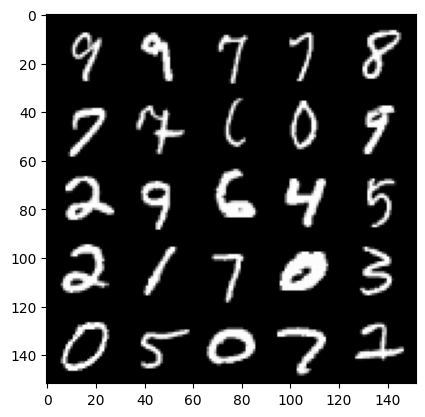

 86%|████████▌ | 403/469 [05:27<00:56,  1.16it/s]

Step 6500: Generator loss: 0.6503305265903474, discriminator loss: 0.7097514028549192


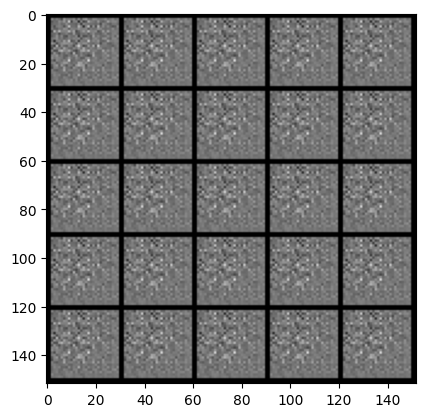

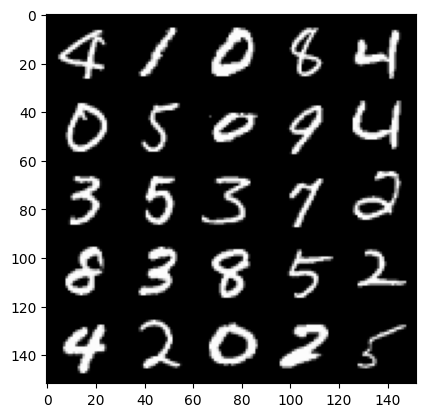

 93%|█████████▎| 434/469 [06:13<00:31,  1.12it/s]

Step 7000: Generator loss: 0.6503295415639875, discriminator loss: 0.7097494006156926


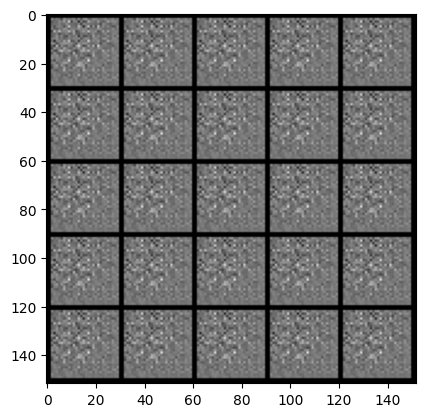

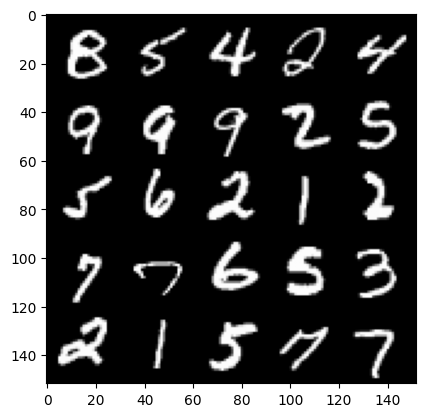

 99%|█████████▉| 465/469 [06:53<00:03,  1.11it/s]

Step 7500: Generator loss: 0.6503284934759141, discriminator loss: 0.7097506269216537


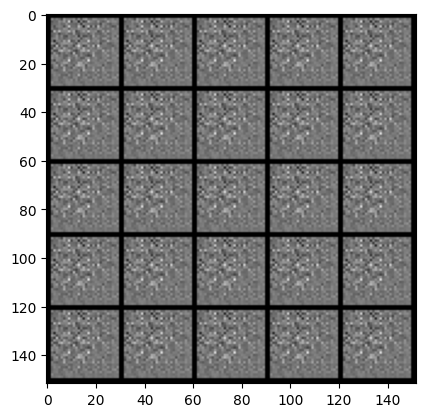

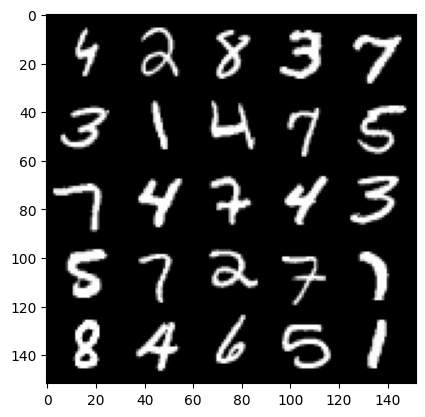

  6%|▌         | 27/469 [00:22<06:00,  1.23it/s]

Step 8000: Generator loss: 0.6503276969194409, discriminator loss: 0.7097522161006926


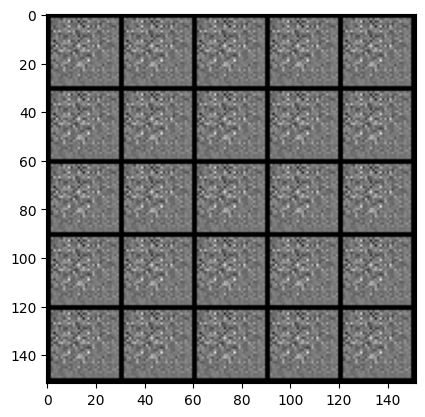

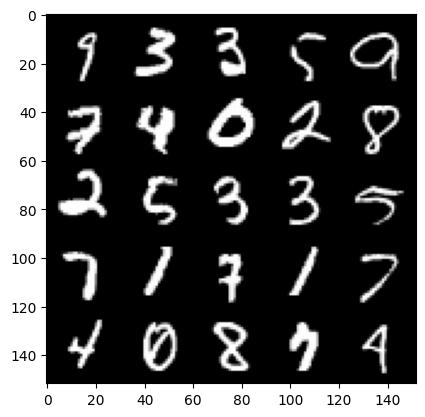

 12%|█▏        | 58/469 [00:44<05:10,  1.32it/s]

Step 8500: Generator loss: 0.6503267453908919, discriminator loss: 0.7097492877244951


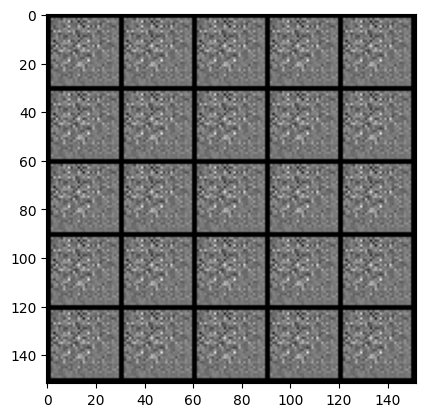

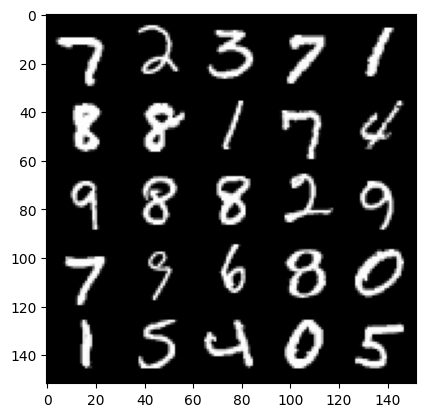

 19%|█▉        | 89/469 [01:06<04:40,  1.36it/s]

Step 9000: Generator loss: 0.6503257840871812, discriminator loss: 0.7097545241117476


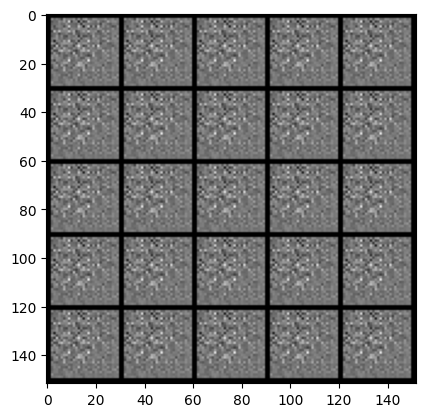

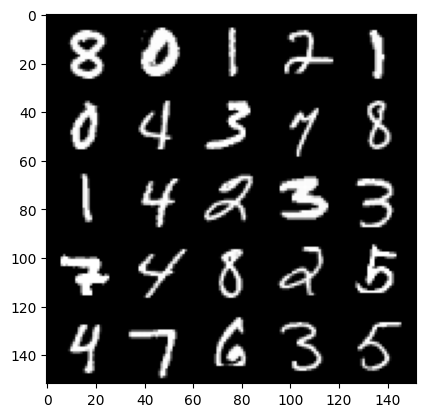

 26%|██▌       | 120/469 [17:11<1:10:59, 12.20s/it]  

Step 9500: Generator loss: 0.6503254386186604, discriminator loss: 0.7097519010305401


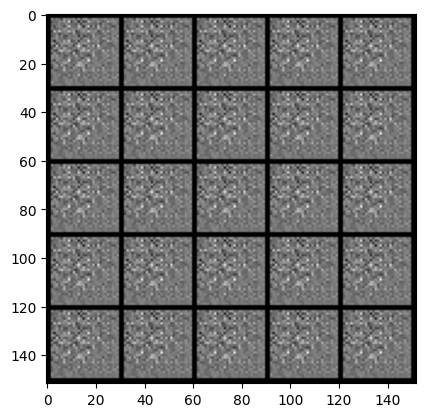

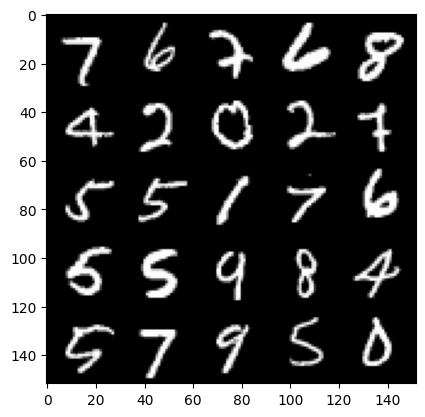

 32%|███▏      | 151/469 [18:07<02:39,  2.00it/s]   

Step 10000: Generator loss: 0.6503249088525771, discriminator loss: 0.7097539803981782


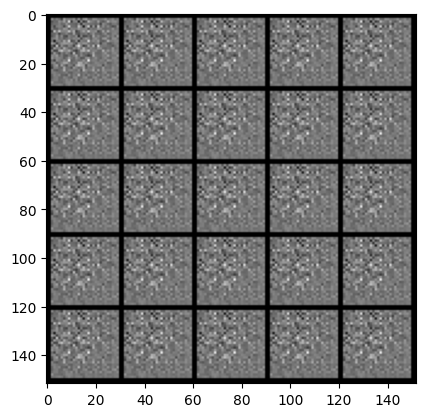

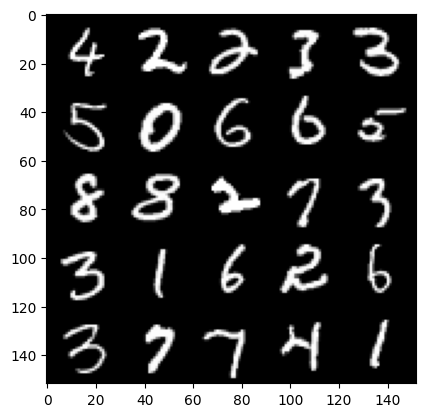

 39%|███▉      | 182/469 [03:31<05:59,  1.25s/it]

Step 10500: Generator loss: 0.6503244773149494, discriminator loss: 0.7097531727552412


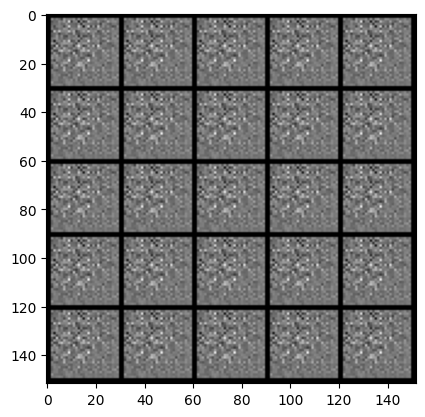

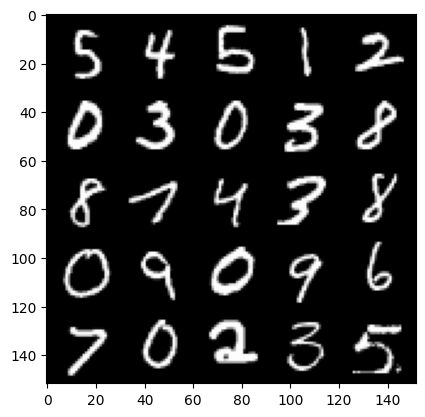

 45%|████▌     | 213/469 [04:16<05:12,  1.22s/it]

Step 11000: Generator loss: 0.6503240926265722, discriminator loss: 0.7097523339986808


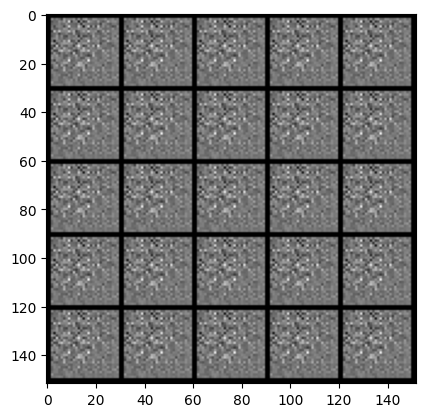

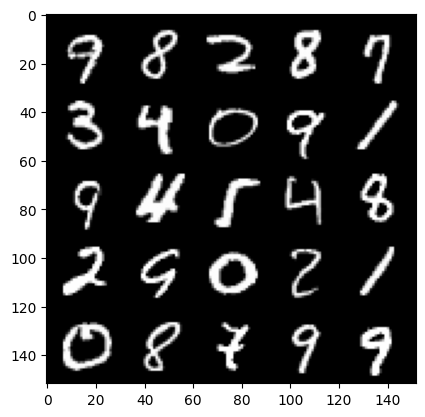

 52%|█████▏    | 244/469 [18:22<02:14,  1.68it/s]   

Step 11500: Generator loss: 0.6503236122131355, discriminator loss: 0.70975686109066


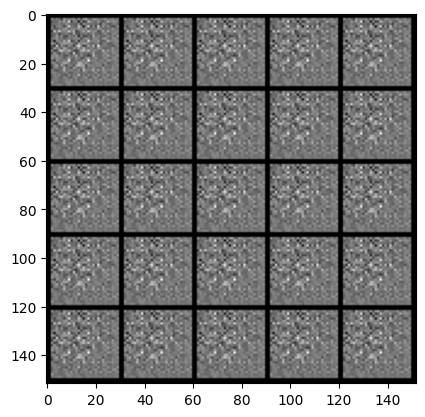

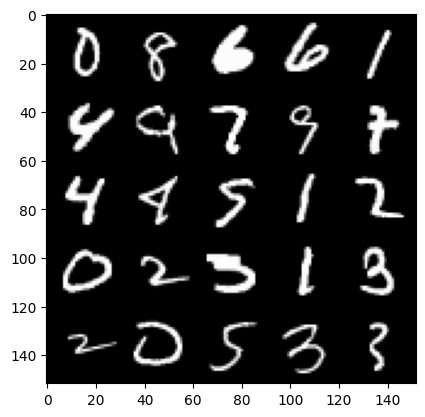

 56%|█████▌    | 261/469 [18:32<14:46,  4.26s/it]


KeyboardInterrupt: 

In [51]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        disc_opt.zero_grad()

        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)

        disc_fake_pred = disc(fake.detach())
        disc_real_pred = disc(real)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss)/2
        # print(disc_loss)
        mean_discriminator_loss += disc_loss.item()/display_step

        disc_loss.backward(retain_graph= True)
        disc_opt.step()


        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        mean_generator_loss += gen_loss.item()/display_step

        gen_loss.backward()
        gen_opt.step()

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1